In [0]:
pip install git+git://github.com/maciejkula/spotlight.git

  Cloning git://github.com/maciejkula/spotlight.git to /tmp/pip-req-build-3i960z1w
  Stored in directory: /tmp/pip-ephem-wheel-cache-skgp99or/wheels/5f/eb/0a/20af178044caa54b089e63026090ab13ca70c45c80a18f7253
Successfully built spotlight


In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Interpretación de los factores latentes

Los métodos de factorización matricial para sistemas de recomendación intentan representar a *usuarios* y *items* en un mismo espacio vectorial n-dimensional en función de sus interacciones.

En este notebook vamos a explorar si podemos extraer información relevante de estas representaciones además de poder hacer recomendaciones.

Para ello vamos a utilizar el dataset *Movielens 100K*, que cuenta con 100K ratings de 943 usuarios en 1682 películas

## Carga de datos

Vamos a obtener los datos de la [página de Grouplens](http://files.grouplens.org/datasets/movielens/ml-100k/).

Leemos primero los metadatos de las películas.

In [0]:
movies = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.item", 
    sep="|", header = None, encoding = "ISO-8859-1"
)
movies.columns = [
    "item_id",  "movie_title", "release_date", "video_release_date",
    "IMDb URL" , "unknown", "Action", "Adventure", "Animation",
    "Children" , "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
    "Thriller", "War", "Western"
]
movies.head()

Posteriormente leemos los datos de los usuarios.

In [0]:
users = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.user", 
    sep="|", header = None, encoding = "ISO-8859-1"
)

users.columns = [
    "user_id", "age", "gender", "occupation", "zip_code"
]

users.head()

Por ultimo leemos las interacciones usuario-película con su rating asociado.

In [0]:
dataset = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u.data", sep = "\t", header = None)
dataset.columns = ["user_id", "item_id", "rating", "timestamp"]
dataset.head()

Por último recodificamos los ids de items y usuarios, ya que vienen numerados de 1 a N y nos interesa que estén de 0 a N-1.

In [0]:
dataset["user_id"] = dataset["user_id"] - 1
dataset["item_id"] = dataset["item_id"] - 1
movies["item_id"] = movies["item_id"] - 1
users["user_id"] = users["user_id"] - 1

## Entrenamiento del modelo de factorización

Para el entrenamiento del modelo vamos a utilizar [spotlight](https://maciejkula.github.io/spotlight/index.html).

In [0]:
from spotlight.interactions import Interactions
from spotlight.factorization.implicit import ImplicitFactorizationModel

Construimos el dataset para que se adecúe al formato de entrada de la librería y entrenamos el modelo.

Vamos a elegir 5 factores latentes y un número elevado de epoch, ya que para el análisis nos da un poco lo mismo el overfit.

In [0]:
interactions = Interactions(dataset["user_id"].values, dataset["item_id"].values)

model = ImplicitFactorizationModel(
    loss='pointwise', 
    embedding_dim=32, 
    n_iter=50,
    random_state=np.random.RandomState(0)
)

model.fit(interactions, verbose = False)

Extraemos los *embeddings*, que representan los factores latentes de usuarios e items.

In [0]:
user_embeddings = model._net.user_embeddings.weight.data.numpy()
item_embeddings = model._net.item_embeddings.weight.data.numpy()

## Exploración de los factores latentes

Tenemos los factores $u_{ij}$, la idea es que si elegimos un factor $u_{aj}$ que represente una película típica de, por ejemplo ciencia ficción y otro $u_{bj}$ que represente una película romántica, podemos definir una dirección $\frac{u_{aj} - u_{bj}}{||u_{aj} - u_{bj}||}$ que represente la tendencia a las películas romanticas o películas de ciencia ficción tanto para usuarios como para items.

Para hallar este valor, solo tenemos que proyectar sobre esa dirección los factores $u_{ij}$.

### Dimensión Ciencia Ficción vs Comedia Romántica

Como película representativa de ciencia ficción tomamos *Star Trek: Generations*.

In [0]:
movies[movies.item_id == 379]

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
379,379,Star Trek: Generations (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Por otro lado, como película representativa de comedia romántica tomamos *La boda de mi mejor amigo*.

In [0]:
movies[movies.item_id == 254]

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
254,254,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Hallamos la dirección y proyectamos los factores latentes de cada película sobre ella para calcular un *score*.

In [0]:
u = item_embeddings[379] - item_embeddings[254]
u_hat = u / (u**2).sum()**0.5
movies["score"] = np.transpose(np.dot(item_embeddings, np.expand_dims(u_hat, 1)))[0]

Si ordenamos las películas de menor a mayor *score* podemos observar que aquellas con un menor *score* son películas románticas mientras que aquellas con mayor son películas de ciencia ficción o fantasía.

In [0]:
movies.sort_values("score").head()

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
254,254,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-8.095102
274,274,Sense and Sensibility (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Sense%20and%2...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-5.637879
814,814,One Fine Day (1996),30-Nov-1996,NaN,http://us.imdb.com/M/title-exact?One%20Fine%20...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-5.299332
236,236,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-4.990129
1011,1011,Private Parts (1997),07-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Private%20Par...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-4.892868


In [0]:
movies.sort_values("score").tail()

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
228,228,Star Trek III: The Search for Spock (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,5.991991
402,402,Batman (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Batman%20(1989),0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,6.041560
664,664,Alien 3 (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Alien%203%20(...,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,6.254703
61,61,Stargate (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Stargate%20(1...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,6.815407
379,379,Star Trek: Generations (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,8.016078


Vamos a hacer el mismo ejercicio per con los usuarios, proyectando sus factores latentes sobre la dimensión calculada.

In [0]:
users["score"] = np.transpose(np.dot(user_embeddings, np.expand_dims(u_hat, 1)))[0]

Si calculamos el score medio por género vemos que las mujeres están más inclinadas a ver películas románticas mientras que los hombres a películas de ciencia ficción.

Por otro lado vemos que los ingenieros y programadores tienen un score mayor mientras que las amas de casa tienen el score mínimo.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


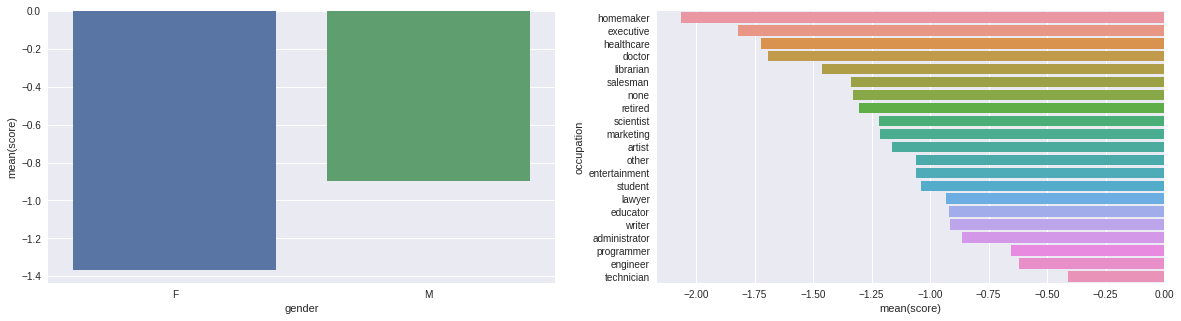

In [0]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (20, 5))

sns.barplot(
    x = "gender", y = "score", 
    data = users.groupby("gender").agg({"score": "mean"}).reset_index(),
    ax = ax_1
)

sns.barplot(
    y = "occupation", x = "score", 
    data = users.groupby("occupation").agg({"score": "mean"})\
      .reset_index().sort_values('score'),
    ax = ax_2
)

plt.show()

### Dimensión *películas antiguas*

In [0]:
movies["release_year"] = movies["release_date"].str.extract("(\d{4})$").astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [0]:
movies[movies["item_id"] == 674]

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score,release_year
674,674,"Nosferatu (Nosferatu, eine Symphonie des Graue...",01-Jan-1922,NaN,"http://us.imdb.com/M/title-exact?Nosferatu,%20...",0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.758008,1922.0


In [0]:
movies[movies["item_id"] == 884]

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score,release_year
884,884,Phantoms (1998),01-Jan-1998,NaN,http://us.imdb.com/M/title-exact?Phantoms+(1998),0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.354297,1998.0


In [0]:
u = item_embeddings[674] - item_embeddings[884]
u_hat = u / (u**2).sum()**0.5
movies["score"] = np.transpose(np.dot(item_embeddings, np.expand_dims(u_hat, 1)))[0]

In [0]:
movies.sort_values("score").head()

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score,release_year
305,305,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Her+Majesty%2...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-5.291117,1997.0
884,884,Phantoms (1998),01-Jan-1998,NaN,http://us.imdb.com/M/title-exact?Phantoms+(1998),0,0,0,0,0,...,1,0,0,0,0,0,0,0,-4.846834,1998.0
279,279,Up Close and Personal (1996),01-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Up%20Close%20...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-4.591436,1996.0
250,250,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-4.537306,1997.0
534,534,Addicted to Love (1997),23-May-1997,NaN,http://us.imdb.com/M/title-exact?Addicted%20to...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-4.499990,1997.0


In [0]:
movies.sort_values("score").tail()

,item_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score,release_year
435,435,"American Werewolf in London, An (1981)",01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?American%20We...,0,0,0,0,0,...,1,0,0,0,0,0,0,0,6.073152,1981.0
431,431,Fantasia (1940),01-Jan-1940,NaN,http://us.imdb.com/M/title-exact?Fantasia%20(1...,0,0,0,1,1,...,0,1,0,0,0,0,0,0,6.151361,1940.0
495,495,It's a Wonderful Life (1946),01-Jan-1946,NaN,http://us.imdb.com/M/title-exact?It's%20a%20Wo...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.235801,1946.0
442,442,"Birds, The (1963)",01-Jan-1963,NaN,"http://us.imdb.com/M/title-exact?Birds,%20The%...",0,0,0,0,0,...,1,0,0,0,0,0,0,0,6.864280,1963.0
674,674,"Nosferatu (Nosferatu, eine Symphonie des Graue...",01-Jan-1922,NaN,"http://us.imdb.com/M/title-exact?Nosferatu,%20...",0,0,0,0,0,...,1,0,0,0,0,0,0,0,7.636474,1922.0
